In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

In [38]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
batch_size = 64
n_epochs = 5
embedding_dim = 100
hidden_size = 256
n_layers = 2

In [39]:
imdb_dataset = load_dataset("imdb")

In [40]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [41]:
# Tokenize and Numericalize the Dataset
print("Tokenizing Dataset...")
def tokenizer_function(examples):
    # The tokenizer handles tokenization, numericalization, and padding/truncation
    return tokenizer(examples["text"], padding = "max_length", truncation = True, max_length = 512)

tokenized_datasets = imdb_dataset.map(tokenizer_function, batched = True)

Tokenizing Dataset...


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [42]:
# Remove the original "text" column and set the format to PyTorch tensor
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [43]:
# Creating DataLoaders
train_loader = DataLoader(tokenized_datasets["train"], batch_size = batch_size, shuffle = True)

test_loader = DataLoader(tokenized_datasets["test"], batch_size = batch_size)

In [44]:
print("\n--- Batch processing check ---")
for batch in train_loader:
    print(f"Labels Shape: {batch['label'].shape}")
    print(f"Input IDs shape: {batch['input_ids'].shape}")
    break


--- Batch processing check ---
Labels Shape: torch.Size([64])
Input IDs shape: torch.Size([64, 512])


In [45]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, num_classes, model_type = "LSTM"):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim)
        self.model_type = model_type
        
        if model_type == "LSTM":
            self.recurrent_layer = nn.LSTM(input_size = embed_dim, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional = True)
            
        elif model_type == "GRU":
            self.recurrent_layer = nn.GRU(input_size = embed_dim, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional = True)
            
        elif model_type == "RNN":
            self.recurrent_layer = nn.RNN(input_size = embed_dim, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional = True)
            
        self.fc = nn.Linear(in_features = hidden_size * 2, out_features = num_classes)  # *2 for bidirectional
        
    def forward(self, input_ids):
        # input_ids shape: [batch_size, seq_len]
        embedded = self.embedding(input_ids)
        # embedded shape: [batch_size, seq_len, embed_dim]
        
        recurrent_out, _ = self.recurrent_layer(embedded)
        # recurrent_out shape: [batch_size, seq_len, hidden_size * 2]
        
        out = self.fc(recurrent_out[:, -1, :])  # Use final hidden state
        return out.squeeze(1)

In [50]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for batch in tqdm(dataloader, desc = "Training"):
        # Access data from the batch dictionary
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device).float()
        
        optimizer.zero_grad()
        prediction = model(input_ids)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.round(torch.sigmoid(prediction))
        total_acc += (preds == labels).sum().item()
        
    return total_loss / len(dataloader.dataset), total_acc / len(dataloader.dataset)

def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device).float()

            predictions = model(input_ids)
            loss = criterion(predictions, labels)

            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(predictions))
            total_acc += (preds == labels).sum().item()

    return total_loss / len(dataloader.dataset), total_acc / len(dataloader.dataset)

In [47]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [48]:
def run_model(model_type):
    print(f"\n{'='*20} Training {model_type} Model {'='*20}")

    model = TextClassifier(
        vocab_size=tokenizer.vocab_size, # Get vocab size from the tokenizer
        embed_dim=embedding_dim,
        hidden_size=hidden_size,
        num_layers=n_layers,
        num_classes=1,
        model_type=model_type
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate_epoch(model, test_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"  Val. Loss: {val_loss:.4f} | Val. Acc: {val_acc*100:.2f}%")

    plot_history(history, model_type)



==================== Training RNN Model ====================

Epoch 1/5


Evaluating: 100%|██████████| 391/391 [00:08<00:00, 46.34it/s]


  Train Loss: 0.0110 | Train Acc: 49.78%
  Val. Loss: 0.0109 | Val. Acc: 50.10%

Epoch 2/5


Evaluating: 100%|██████████| 391/391 [00:07<00:00, 52.29it/s]


  Train Loss: 0.0109 | Train Acc: 49.69%
  Val. Loss: 0.0110 | Val. Acc: 50.00%

Epoch 3/5


Evaluating: 100%|██████████| 391/391 [00:07<00:00, 52.09it/s]


  Train Loss: 0.0109 | Train Acc: 49.69%
  Val. Loss: 0.0109 | Val. Acc: 50.03%

Epoch 4/5


Evaluating: 100%|██████████| 391/391 [00:07<00:00, 49.75it/s]


  Train Loss: 0.0109 | Train Acc: 50.00%
  Val. Loss: 0.0110 | Val. Acc: 50.09%

Epoch 5/5


Evaluating: 100%|██████████| 391/391 [00:07<00:00, 51.82it/s]


  Train Loss: 0.0109 | Train Acc: 50.37%
  Val. Loss: 0.0109 | Val. Acc: 50.00%


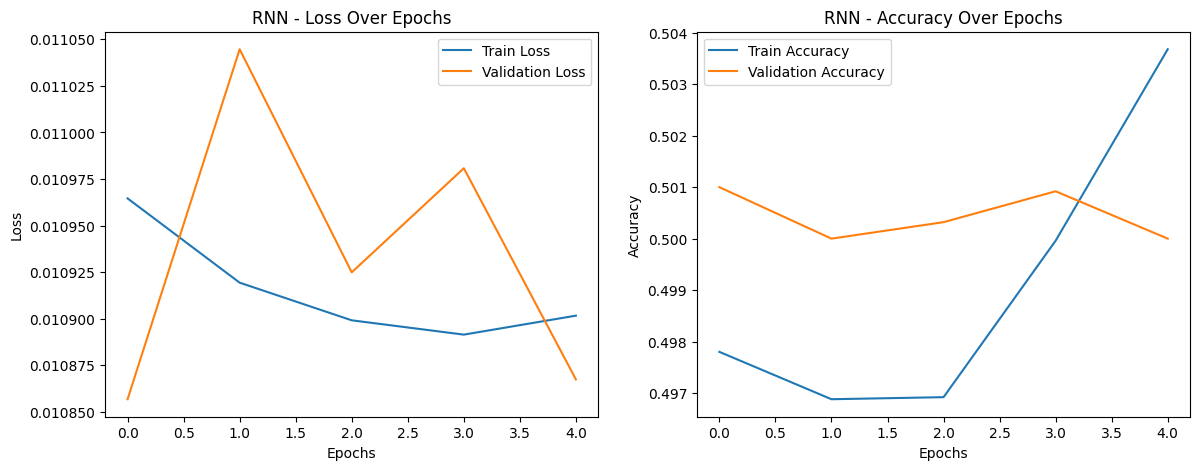

In [51]:
run_model('RNN')


==================== Training GRU Model ====================

Epoch 1/5


Evaluating: 100%|██████████| 391/391 [00:21<00:00, 18.13it/s]


  Train Loss: 0.0109 | Train Acc: 49.86%
  Val. Loss: 0.0108 | Val. Acc: 50.00%

Epoch 2/5


Evaluating: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s]


  Train Loss: 0.0108 | Train Acc: 50.41%
  Val. Loss: 0.0108 | Val. Acc: 50.17%

Epoch 3/5


Evaluating: 100%|██████████| 391/391 [00:21<00:00, 18.21it/s]


  Train Loss: 0.0108 | Train Acc: 51.78%
  Val. Loss: 0.0108 | Val. Acc: 50.01%

Epoch 4/5


Evaluating: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s]


  Train Loss: 0.0079 | Train Acc: 73.56%
  Val. Loss: 0.0051 | Val. Acc: 86.46%

Epoch 5/5


Evaluating: 100%|██████████| 391/391 [00:21<00:00, 18.29it/s]


  Train Loss: 0.0040 | Train Acc: 90.06%
  Val. Loss: 0.0044 | Val. Acc: 88.24%


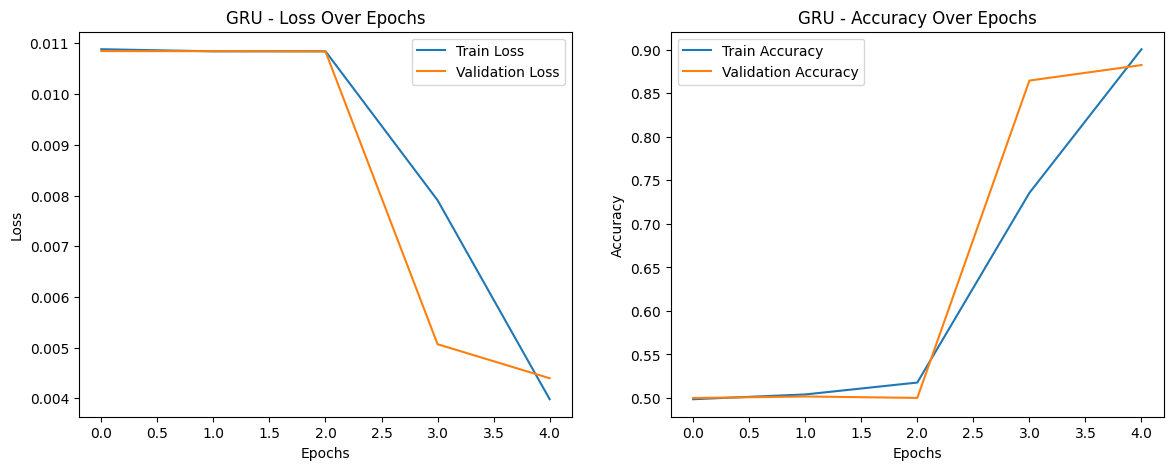

In [52]:
run_model('GRU')


==================== Training LSTM Model ====================

Epoch 1/5


Evaluating: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s]


  Train Loss: 0.0108 | Train Acc: 50.80%
  Val. Loss: 0.0108 | Val. Acc: 50.38%

Epoch 2/5


Evaluating: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s]


  Train Loss: 0.0108 | Train Acc: 50.54%
  Val. Loss: 0.0108 | Val. Acc: 50.15%

Epoch 3/5


Evaluating: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s]


  Train Loss: 0.0108 | Train Acc: 51.22%
  Val. Loss: 0.0108 | Val. Acc: 50.18%

Epoch 4/5


Evaluating: 100%|██████████| 391/391 [00:22<00:00, 17.57it/s]


  Train Loss: 0.0108 | Train Acc: 51.58%
  Val. Loss: 0.0109 | Val. Acc: 50.34%

Epoch 5/5


Evaluating: 100%|██████████| 391/391 [01:31<00:00,  4.26it/s]


  Train Loss: 0.0107 | Train Acc: 52.60%
  Val. Loss: 0.0109 | Val. Acc: 51.12%


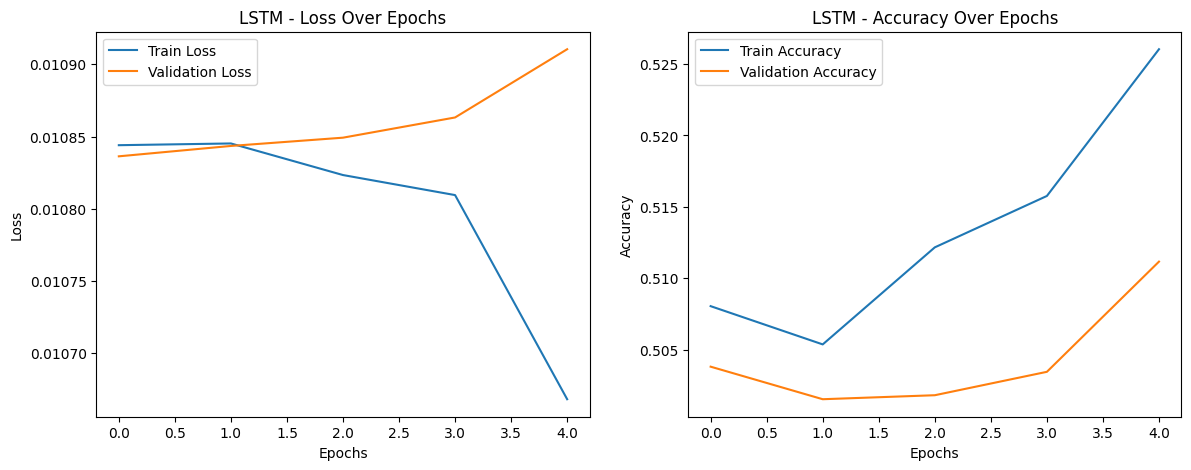

In [53]:
run_model('LSTM')